In [1]:
import matplotlib.pyplot as plt
import numpy as np

import galaxy_tools as gal
import general_tools as gen

%matplotlib inline


Couldn't import numba. Missing:
abg_python.all_utils.get_cylindrical_velocities
Missing firefly, obtain it at http://github.com/ageller/Firefly or pip install firefly.


### Note:
This notebook was set up to run on GreenPlanet based on the paths used.

## Gas Extinction

This is an overview of calculating the extinction due to gas extinction in the mock images. 

The general absorption calculation is:

$$I_{\lambda} = I_{\lambda,0} e^{-\tau_{\lambda}}$$ 

Where $\tau$ is the optical depth.

$$\tau = \sigma N_d $$

Where $\sigma$ is the scattering cross section and $N_d$ is is the dust grain column density.  

For these calculations the scattering cross section is assumed to be constant for a given band. 

$e^{-\tau_{\lambda}}$ is multiplied by the luminosity in the pixel, to determine the absorption for everything physically behind the gas


### Gas Calculation for Mock Images

The cross section $\sigma$ is calulating using the cross_section function which calculates the cross section per solar metalicity.

The cross section is based on the photoelectric absorption from Morrison: \
https://articles.adsabs.harvard.edu/pdf/1983ApJ...270..119M

and the Dust extinction from Pei: \
https://articles.adsabs.harvard.edu/pdf/1992ApJ...395..130P


The column density $N_d$ is calculated based on gas$_{mass}$ ( gas$_{metal}$ / solar$_{metal}$ ).

The gas$_{metal}$ is the metalicity (everything not H, He) in units of mass fraction and the solar$_{metal}$ is 0.02. 


### Calulation of the Gas Map 

Below shows the a sum of the gas dust mass map. The mock image returns the gas map, and so I recreate the mass map with the particles. 

The pixel size does not change the gas map accumulative mass plot, although smaller pixel sizes makes it more stochastic.

The limvalue is the physical limit mask for the partical mask and the FOV is the physical limit for the image. Both masks use the limits for a spherical radius. 


In [2]:
sim = 'm11a_res2100'

snap_num = 600

# path to the directory holding the simulation snapshot 
sim_path =  '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/output/hdf5/snapdir_'+str(snap_num)+'/'

# path to the directory holding the halo files for the simulation
halo_path = '/data17/grenache/aalazar/FIRE/GVB/'+str(sim)+'/halo/rockstar_dm/hdf5/'


In [3]:
# This loads the halo file
# host=True means it only returns the host halo information, otherwise it returns all the halos
# filetype='hdf5' indicate the halo file type, some halos are filetype='ascii'
# hostnumber indicates which host halo you are looking at. Only need to worry about this for the elvis pairs.
        #use hostnumber=2 to get the halo info for the second host halo. 
        #ex: halo_themla = gal.load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=1)
        #    halo_louise = gal.load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=2)

halo = gal.load_halo(halo_path, snap_num, host=True, filetype='hdf5', hostnumber=1)


In [4]:
# This loads the star and gas particle
# It only loads the parameters I need for the mock images
# gas_temp=True returns the particle information to calculate the temperature of gas

star_snapdict, gas_snapdict = gal.load_sim(sim_path,snap_num,gas_temp=True)


In [5]:
# This centers star and gas dictionaries on the host halo
# If orient=True, then it will rotate the particles based on the disk orientation
# If lim=True, then it masks out the particles beyond the limvalue
    # Have lim=False if you want to carry around all the particles
    # I chose to mask out particles beyond the virial radius

limvalue = halo['Halfmass_Radius'].values[0] / 5

star_snapdict, gas_snapdict, halo = gal.mask_sim_to_halo(star_snapdict=star_snapdict, 
                                                         gas_snapdict=gas_snapdict, 
                                                         host_halo=halo, 
                                                         orient=True, 
                                                         lim = True, 
                                                         limvalue = limvalue 
                                                        )


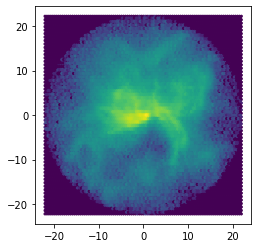

In [6]:
plt.hexbin(gas_snapdict['Coordinates'][:,0],gas_snapdict['Coordinates'][:,1], bins='log')
plt.gca().set_aspect(1)

In [7]:
mass_scaler = 1e-10
bands = [1,2,3]

#Field of view for the image in kpc 
FOV = limvalue/2
#Number of pixels
pixels = 500
# the axis it is projected on, 'xy', 'yz', 'zx'
view = 'xy' 
# use the center of mass or center of light, 'light', 'mass'
center = 'none'
# the limiting surface brightness, if you dont want to limit it set it equal to zero
minden = gen.mag_to_lum_SB(29,None) # I set it to 29 mag/arcsec^2. This function convers it to lum/kpc^2

return_type = 'gas_mass'

gas_mass = gal.get_mock_observation(star_snapdict,
                                    gas_snapdict,
                                    bands = bands,
                                    FOV = FOV,
                                    mass_scaler = mass_scaler,
                                    pixels = pixels,
                                    view = view,
                                    minden = minden,
                                    center = center,
                                    return_type = return_type
                                   )


Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
Projecting with attenuation...
total lum before attenuation in each band (Lsun/1e10): [0.02037181 0.01462807 0.01069984]
opacity in each band: [1585.97915621 1154.44253194  799.38644653]
total gas mass: 0.0051351109647589845


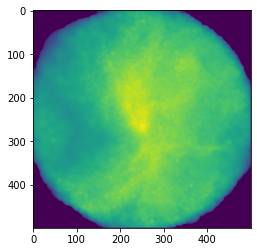

In [8]:
plt.imshow(gas_mass**0.1)

In [9]:
#Calculate the dust mass. 
gas_mass_metal = gas_snapdict['Masses'] * (gas_snapdict['Metallicity'] / 0.02) 

In [10]:
image = gas_mass 
pixels = len(image) 
nmeasure = 100 

half_pix_size  = FOV / pixels # distance from center of pixel to edge 
x_coord_kpc = np.linspace(-FOV + half_pix_size, FOV - half_pix_size, num=pixels) 
x_coord_kpc = np.array([x_coord_kpc,]*pixels) 
y_coord_kpc = np.linspace(FOV - half_pix_size, -FOV + half_pix_size, num=pixels) 
y_coord_kpc = np.array([y_coord_kpc,]*pixels).transpose()

radius = np.linspace(4*half_pix_size,FOV + half_pix_size,num=nmeasure)     
sum_gas_im = np.zeros(len(radius))

for i in range(len(radius)):
    rmask = ((x_coord_kpc)**2 + (y_coord_kpc)**2  <  radius[i]**2)
    sum_gas_im[i] = np.sum(image[rmask]) * 1e10
    

In [11]:
sum_gas_part = np.zeros(len(radius))

for i in range(len(radius)):
    
    rmask = (((gas_snapdict['Coordinates'][:,0]**2 + 
               gas_snapdict['Coordinates'][:,1]**2)  <  radius[i]**2) & 
             ((gas_snapdict['Coordinates'][:,0]**2 + 
               gas_snapdict['Coordinates'][:,1]**2 + 
               gas_snapdict['Coordinates'][:,2]**2) < FOV**2))
    
    sum_gas_part[i] = np.sum(gas_mass_metal[rmask]) 
    

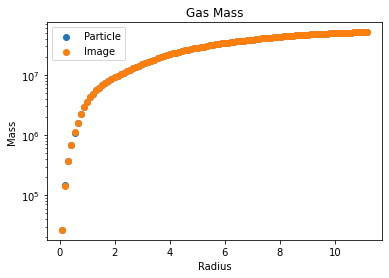

In [12]:
plt.scatter(radius, sum_gas_part, label='Particle')
plt.scatter(radius, sum_gas_im, label='Image')
plt.xlabel('Radius')
plt.ylabel('Mass')
plt.title('Gas Mass')
plt.yscale('log')
plt.legend()

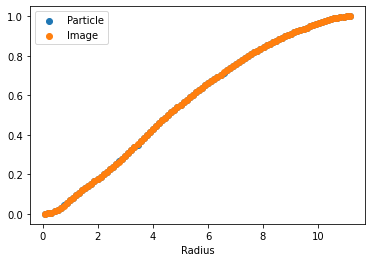

In [13]:
plt.scatter(radius, sum_gas_part/sum_gas_part[-1] , label='Particle')
plt.scatter(radius, sum_gas_im/sum_gas_im[-1], label='Image')
plt.xlabel('Radius')
plt.legend()

Text(0.5, 0, 'Radius')

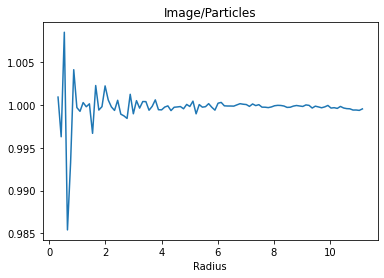

In [14]:
plt.plot(radius[2:], sum_gas_im[2:]/sum_gas_part[2:])
plt.title('Image/Particles')
plt.xlabel('Radius')

In [15]:
print(f'Image Gas Mass: {sum_gas_im[-1] * 1e-10:.5f}')
      
print(f'Particle Gas Mass: {sum_gas_part[-1]* 1e-10:.5f}')

print(f'Image vs Particle Mass: {sum_gas_im[-1]/sum_gas_part[-1]:.5f}')


Image Gas Mass: 0.00513
Particle Gas Mass: 0.00514
Image vs Particle Mass: 0.99953
